In [1]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

2024-09-08 20:02:41.016564: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 20:02:41.068864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 20:02:41.807056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
# Define paths
base_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/MobileNet'
dataset_dir = '/home/user/GPU_CSE/Kirti/Dataset_for_Code_Development/Dataset_for_5_classes_by_Sir/clean_train_partition'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 requires images of size 224x224
batch_size = 32
num_classes = len(next(os.walk(dataset_dir))[1])  # number of class folders
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

In [6]:
# Function to create train, validation, and test splits
def create_splits():
    try:
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        if not os.path.exists(validation_dir):
            os.makedirs(validation_dir)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
    
        for class_name in os.listdir(dataset_dir):        
            train_class_path = os.path.join(train_dir, class_name)        
            if not os.path.exists(train_class_path):
                os.makedirs(train_class_path)        
            
            test_class_path = os.path.join(test_dir, class_name)        
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)        
    
            validation_class_dir = os.path.join(validation_dir, class_name)       
            if not os.path.exists(validation_class_dir):
                os.makedirs(validation_class_dir)        
        
        for class_name in os.listdir(dataset_dir):        
            class_path = os.path.join(dataset_dir, class_name)
            
            if os.path.isdir(class_path):
                images = os.listdir(class_path)
                random.shuffle(images)
                train_split = int(train_ratio * len(images))
                validation_split = int(validation_ratio * len(images))
                
                train_images = images[:train_split]
                validation_images = images[train_split:train_split + validation_split]
                test_images = images[train_split + validation_split:]
    
                for image in train_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))
                for image in validation_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(validation_dir, class_name, image))
                for image in test_images:
                    shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))
    except Exception as err:
        print("Error:", str(err))

In [7]:
# Split the dataset
create_splits()

In [8]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1083 images belonging to 5 classes.
Found 230 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


In [11]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_1.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2024-09-08 20:02:44.015601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46136 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


2024-09-08 20:02:48.320568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-09-08 20:02:48.623185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-08 20:02:48.683105: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb6aa768330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-08 20:02:48.683140: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-09-08 20:02:48.691561: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-08 20:02:48.855977: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

33/33 [==============================] - ETA: 0s - loss: 2.1803 - accuracy: 0.2236

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 422ms/step - loss: 2.1803 - accuracy: 0.2236 - val_loss: 1.8791 - val_accuracy: 0.1830
Epoch 2/50
33/33 [==============================] - 14s 430ms/step - loss: 2.0986 - accuracy: 0.2093 - val_loss: 1.8160 - val_accuracy: 0.1964
Epoch 3/50
33/33 [==============================] - 14s 428ms/step - loss: 2.0375 - accuracy: 0.2017 - val_loss: 1.7946 - val_accuracy: 0.1875
Epoch 4/50
33/33 [==============================] - 14s 425ms/step - loss: 1.9590 - accuracy: 0.2379 - val_loss: 1.7804 - val_accuracy: 0.1786
Epoch 5/50
33/33 [==============================] - 14s 420ms/step - loss: 1.9206 - accuracy: 0.2350 - val_loss: 1.7929 - val_accuracy: 0.1964
Epoch 6/50
33/33 [==============================] - 14s 424ms/step - loss: 1.7958 - accuracy: 0.2531 - val_loss: 1.7719 - val_accuracy: 0.2143
Epoch 7/50
33/33 [==============================] - 14s 420ms/step - loss: 1.8049 - accuracy: 0.2512 - val_loss: 1.7753 - val_accuracy: 0.2143
Epoch 8/50

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 81ms/step - loss: 1.7306 - accuracy: 0.2301
Test accuracy: 0.23


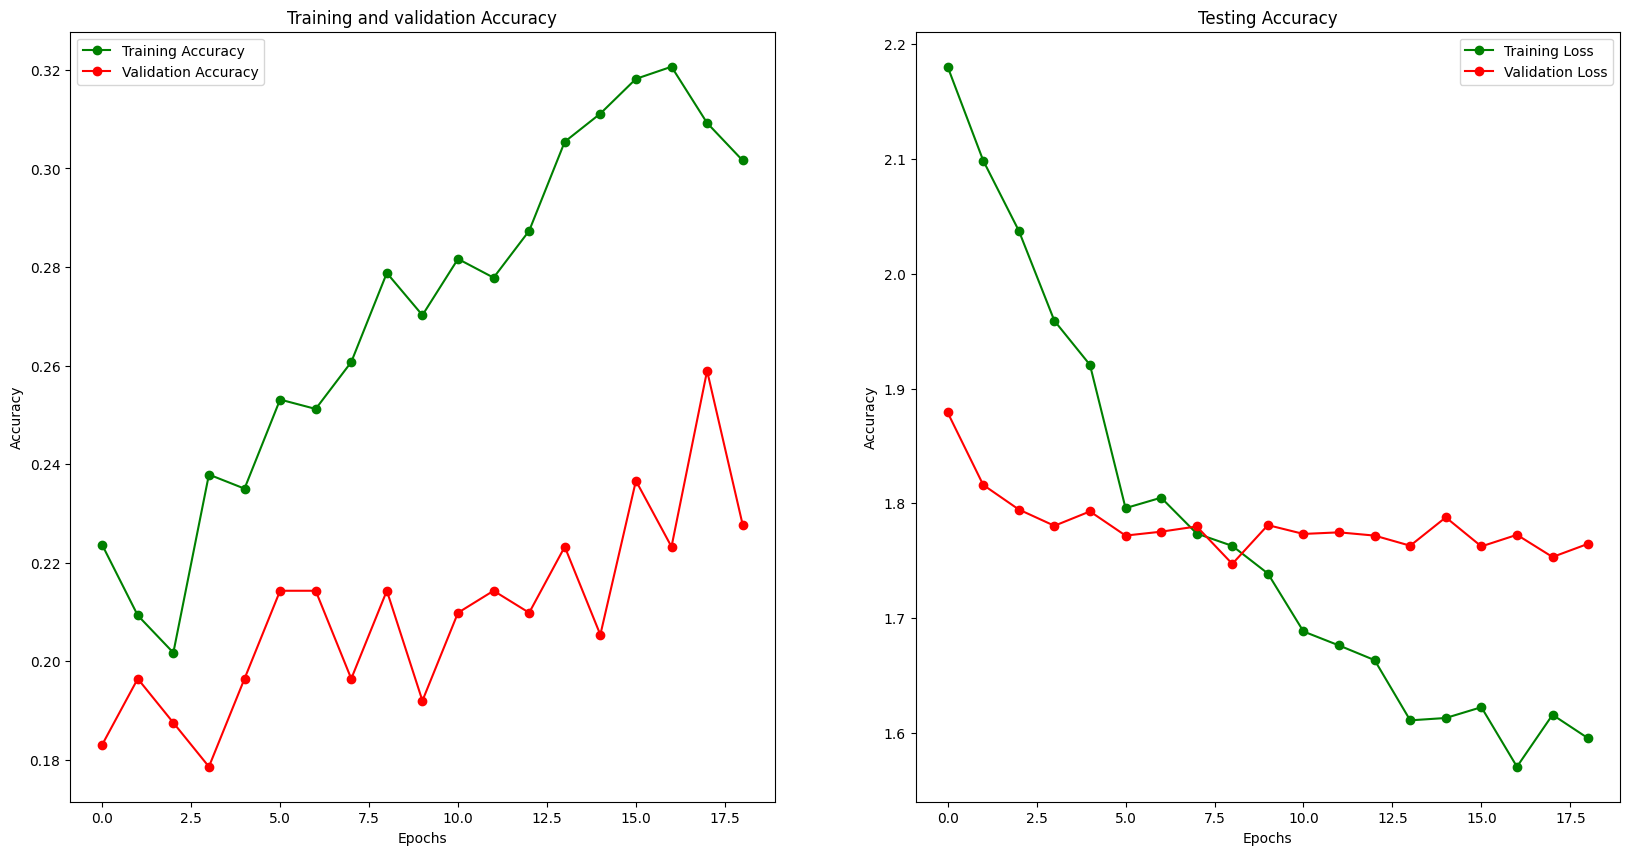

In [14]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 77ms/step


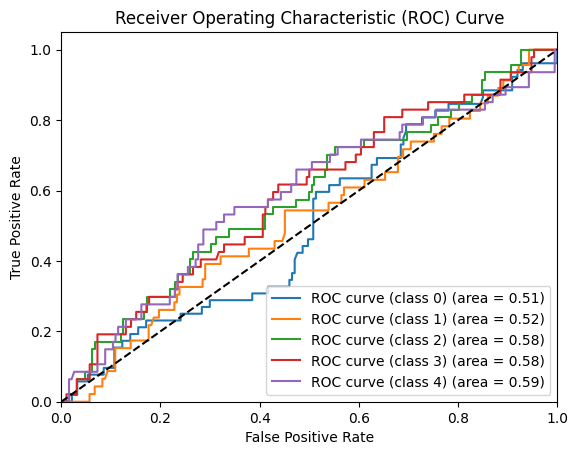

In [15]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 1 

In [16]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 1s 68ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.19
Precision: 0.24
Recall: 0.19
F1 Score: 0.17
F2 Score: 0.18


In [17]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 75ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.48


# Architecture No 2

In [18]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_2.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.9712 - accuracy: 0.1960

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 415ms/step - loss: 1.9712 - accuracy: 0.1960 - val_loss: 1.6839 - val_accuracy: 0.2366
Epoch 2/50
33/33 [==============================] - 15s 439ms/step - loss: 1.8389 - accuracy: 0.2320 - val_loss: 1.6434 - val_accuracy: 0.2545
Epoch 3/50
33/33 [==============================] - 14s 422ms/step - loss: 1.8148 - accuracy: 0.2245 - val_loss: 1.6315 - val_accuracy: 0.2589
Epoch 4/50
33/33 [==============================] - 14s 424ms/step - loss: 1.7672 - accuracy: 0.2521 - val_loss: 1.6251 - val_accuracy: 0.2812
Epoch 5/50
33/33 [==============================] - 14s 420ms/step - loss: 1.7705 - accuracy: 0.2540 - val_loss: 1.6109 - val_accuracy: 0.2768
Epoch 6/50
33/33 [==============================] - 14s 419ms/step - loss: 1.6905 - accuracy: 0.2576 - val_loss: 1.6034 - val_accuracy: 0.2812
Epoch 7/50
33/33 [==============================] - 14s 410ms/step - loss: 1.7373 - accuracy: 0.2483 - val_loss: 1.6202 - val_accuracy: 0.2812
Epoch 8/50

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 65ms/step - loss: 1.6572 - accuracy: 0.2762
Test accuracy: 0.28


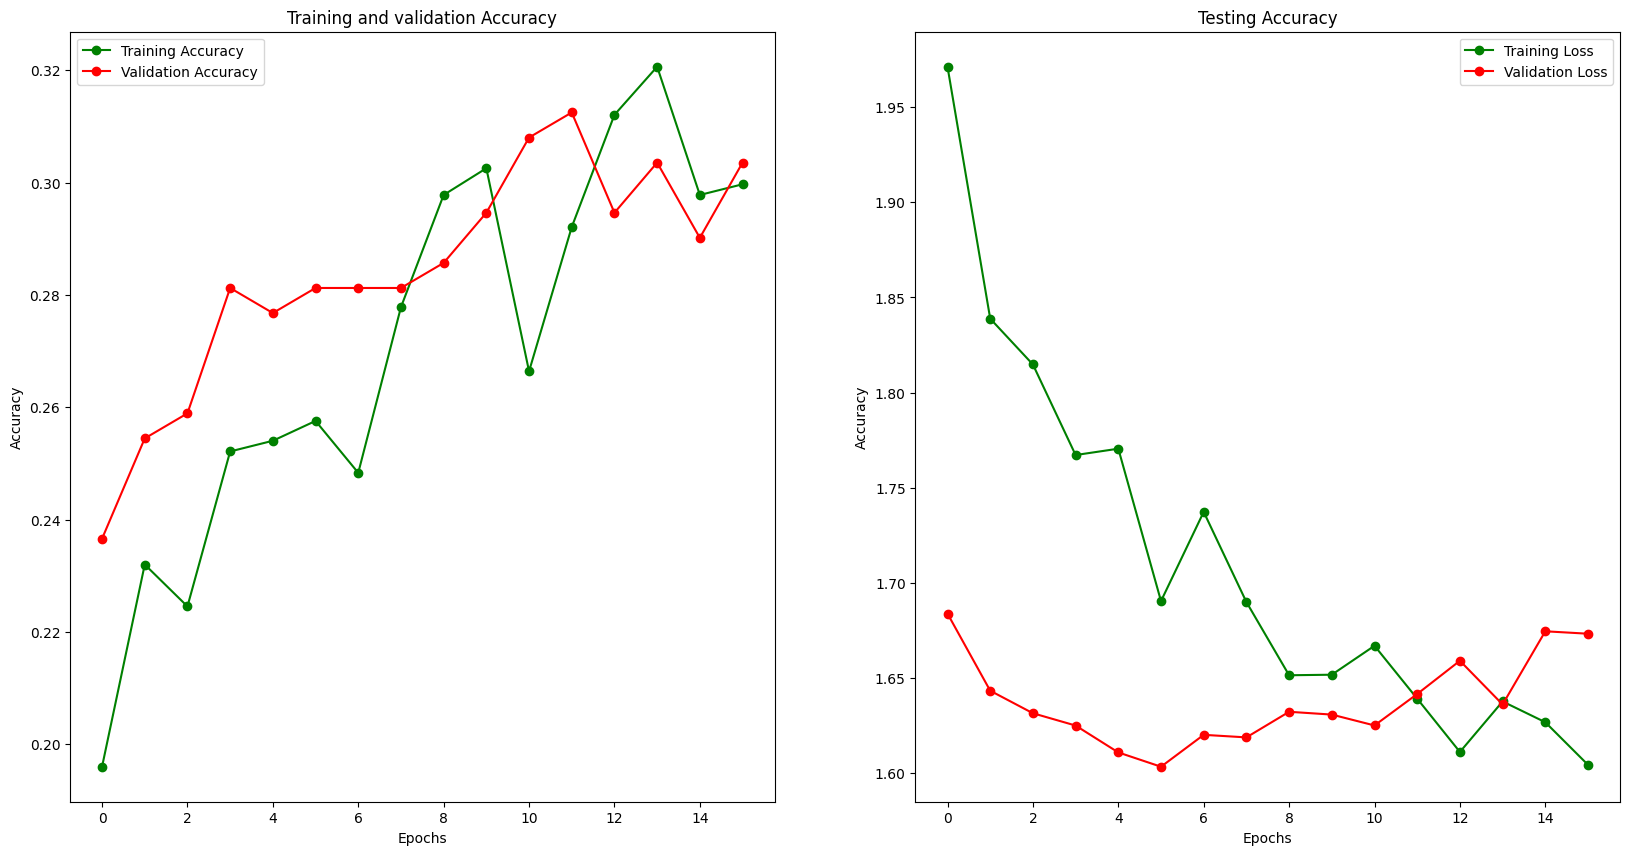

In [21]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 68ms/step


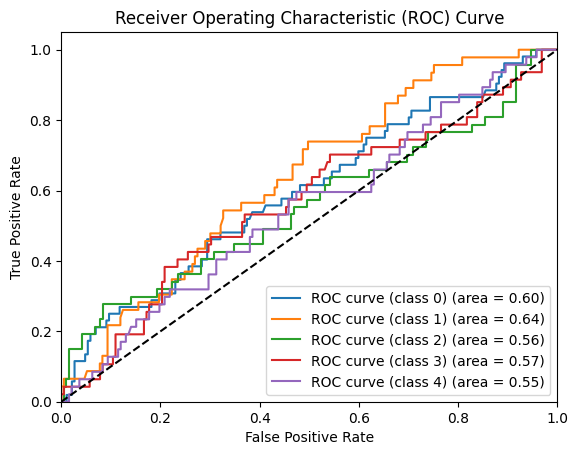

In [22]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 2 

In [23]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 1s 66ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.19
Precision: 0.19
Recall: 0.19
F1 Score: 0.18
F2 Score: 0.18


In [24]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 66ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.43


# Architecture No 4

In [25]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-3:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_4.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8142 - accuracy: 0.2531

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 420ms/step - loss: 1.8142 - accuracy: 0.2531 - val_loss: 1.6362 - val_accuracy: 0.1964
Epoch 2/50
33/33 [==============================] - 14s 424ms/step - loss: 1.6318 - accuracy: 0.3153 - val_loss: 1.6300 - val_accuracy: 0.2054
Epoch 3/50
33/33 [==============================] - 14s 419ms/step - loss: 1.5242 - accuracy: 0.3616 - val_loss: 1.6164 - val_accuracy: 0.2768
Epoch 4/50
33/33 [==============================] - 14s 414ms/step - loss: 1.5205 - accuracy: 0.3587 - val_loss: 1.6495 - val_accuracy: 0.2679
Epoch 5/50
33/33 [==============================] - 14s 418ms/step - loss: 1.4675 - accuracy: 0.3863 - val_loss: 1.6446 - val_accuracy: 0.2679
Epoch 6/50
33/33 [==============================] - 14s 414ms/step - loss: 1.4066 - accuracy: 0.4301 - val_loss: 1.6429 - val_accuracy: 0.2679
Epoch 7/50
33/33 [==============================] - 14s 417ms/step - loss: 1.3642 - accuracy: 0.4367 - val_loss: 1.6957 - val_accuracy: 0.2634
Epoch 8/50

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 78ms/step - loss: 1.6036 - accuracy: 0.3096
Test accuracy: 0.31


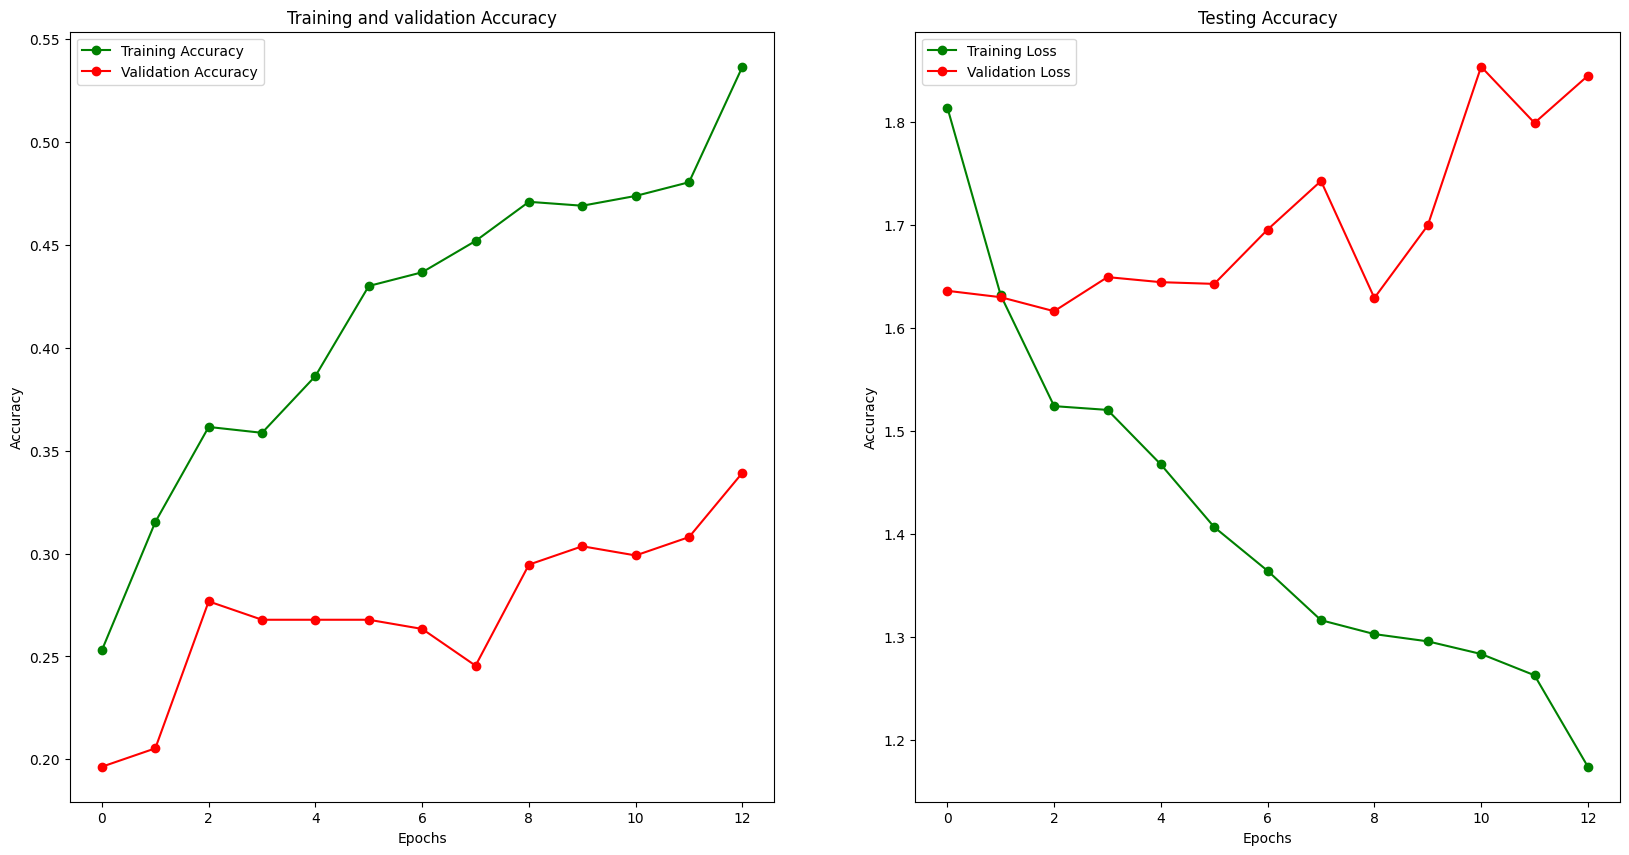

In [28]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 65ms/step


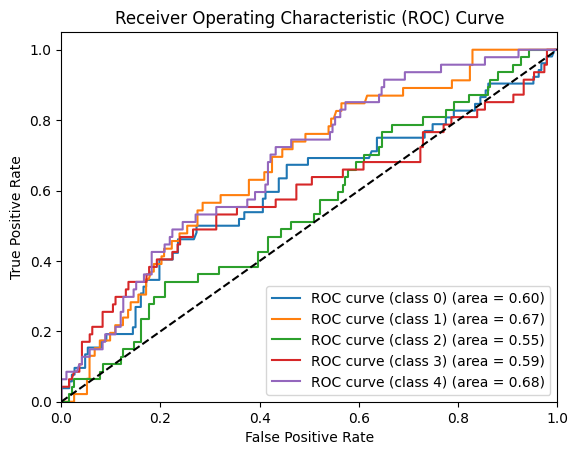

In [29]:
from sklearn.metrics import roc_curve,auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Metric Report Calculation for Architecture No 4 

In [30]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')


8/8 [==============================] - 1s 66ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.17
Precision: 0.17
Recall: 0.17
F1 Score: 0.15
F2 Score: 0.16


In [31]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 65ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.52


# Architecture No 5

In [32]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_5.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [33]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8350 - accuracy: 0.2550

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 426ms/step - loss: 1.8350 - accuracy: 0.2550 - val_loss: 1.6318 - val_accuracy: 0.2634
Epoch 2/50
33/33 [==============================] - 14s 422ms/step - loss: 1.6321 - accuracy: 0.3235 - val_loss: 1.6140 - val_accuracy: 0.2812
Epoch 3/50
33/33 [==============================] - 14s 415ms/step - loss: 1.5667 - accuracy: 0.3225 - val_loss: 1.6214 - val_accuracy: 0.2768
Epoch 4/50
33/33 [==============================] - 14s 417ms/step - loss: 1.4756 - accuracy: 0.3759 - val_loss: 1.6665 - val_accuracy: 0.2723
Epoch 5/50
33/33 [==============================] - 14s 416ms/step - loss: 1.4547 - accuracy: 0.3958 - val_loss: 1.6597 - val_accuracy: 0.2812
Epoch 6/50
33/33 [==============================] - 14s 426ms/step - loss: 1.4397 - accuracy: 0.4053 - val_loss: 1.6123 - val_accuracy: 0.3036
Epoch 7/50
33/33 [==============================] - 14s 419ms/step - loss: 1.3730 - accuracy: 0.4328 - val_loss: 1.6235 - val_accuracy: 0.2991
Epoch 8/50

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 67ms/step - loss: 1.5796 - accuracy: 0.2971
Test accuracy: 0.30


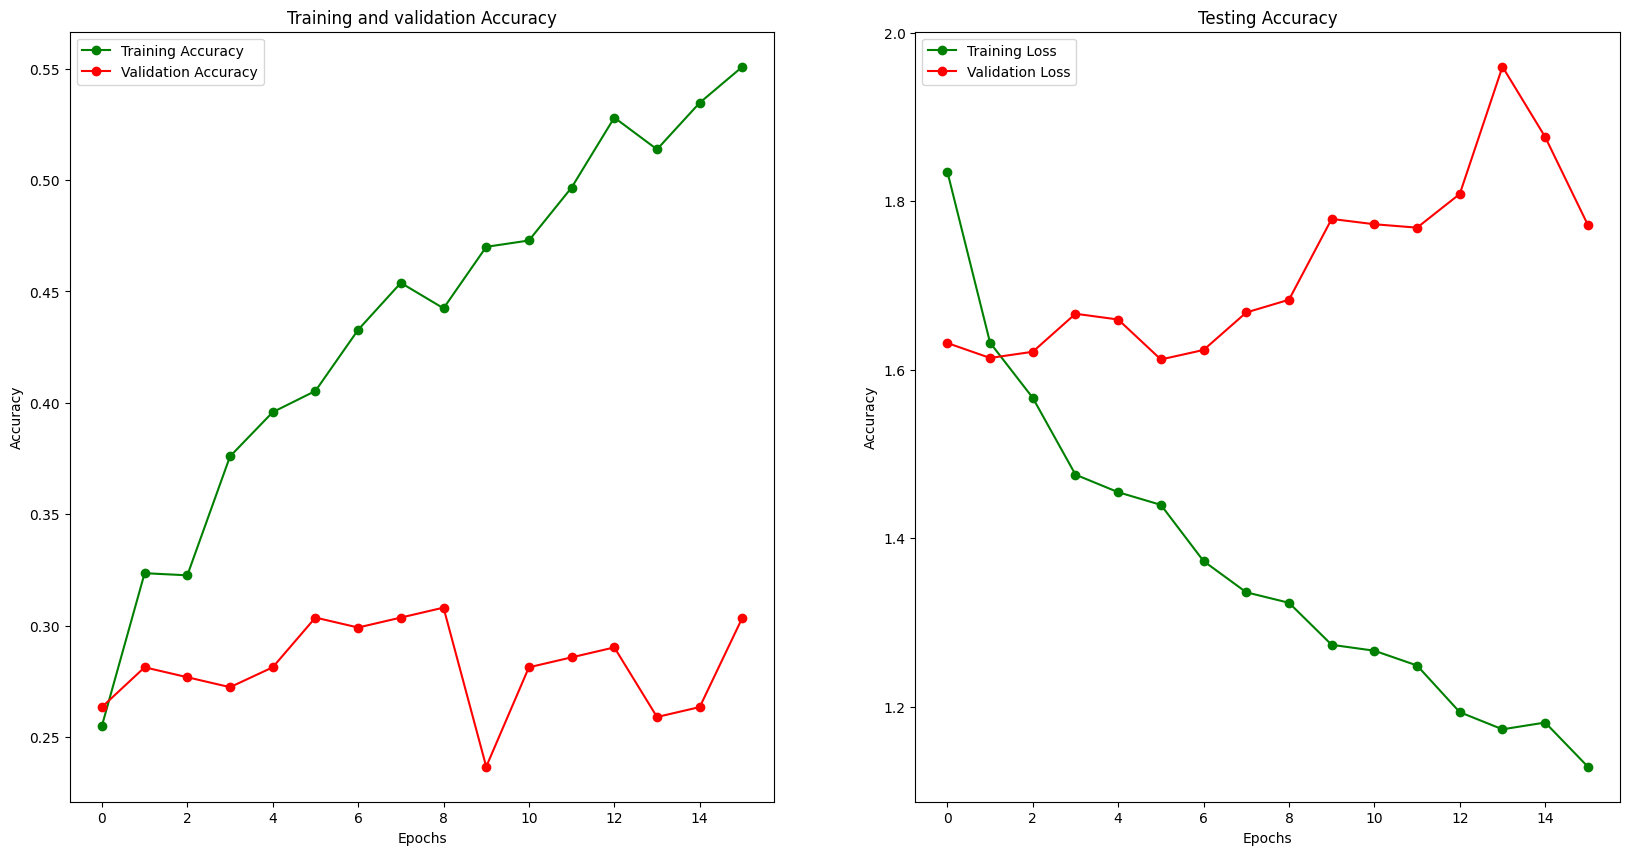

In [35]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 77ms/step


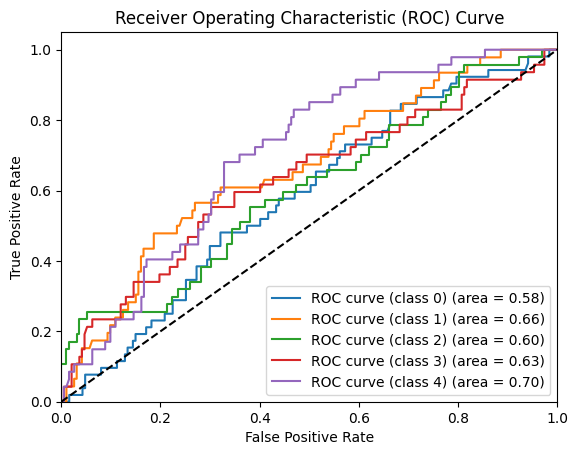

In [36]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 5 

In [37]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 1s 64ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.22
Precision: 0.22
Recall: 0.22
F1 Score: 0.21
F2 Score: 0.22


In [39]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 77ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.53


# Architecture No 6

In [40]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(1024, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(64, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_6.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 2.0612 - accuracy: 0.2331

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 17s 418ms/step - loss: 2.0612 - accuracy: 0.2331 - val_loss: 1.7007 - val_accuracy: 0.2232
Epoch 2/50
33/33 [==============================] - 14s 419ms/step - loss: 1.7135 - accuracy: 0.2626 - val_loss: 1.7007 - val_accuracy: 0.2277
Epoch 3/50
33/33 [==============================] - 14s 425ms/step - loss: 1.6251 - accuracy: 0.3073 - val_loss: 1.6049 - val_accuracy: 0.2857
Epoch 4/50
33/33 [==============================] - 14s 420ms/step - loss: 1.5991 - accuracy: 0.3073 - val_loss: 1.5936 - val_accuracy: 0.2991
Epoch 5/50
33/33 [==============================] - 14s 432ms/step - loss: 1.6174 - accuracy: 0.3149 - val_loss: 1.5508 - val_accuracy: 0.2812
Epoch 6/50
33/33 [==============================] - 14s 416ms/step - loss: 1.5366 - accuracy: 0.3406 - val_loss: 1.5676 - val_accuracy: 0.2634
Epoch 7/50
33/33 [==============================] - 14s 415ms/step - loss: 1.5278 - accuracy: 0.3387 - val_loss: 1.5894 - val_accuracy: 0.2812
Epoch 8/50

In [42]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 81ms/step - loss: 1.6002 - accuracy: 0.2678
Test accuracy: 0.27


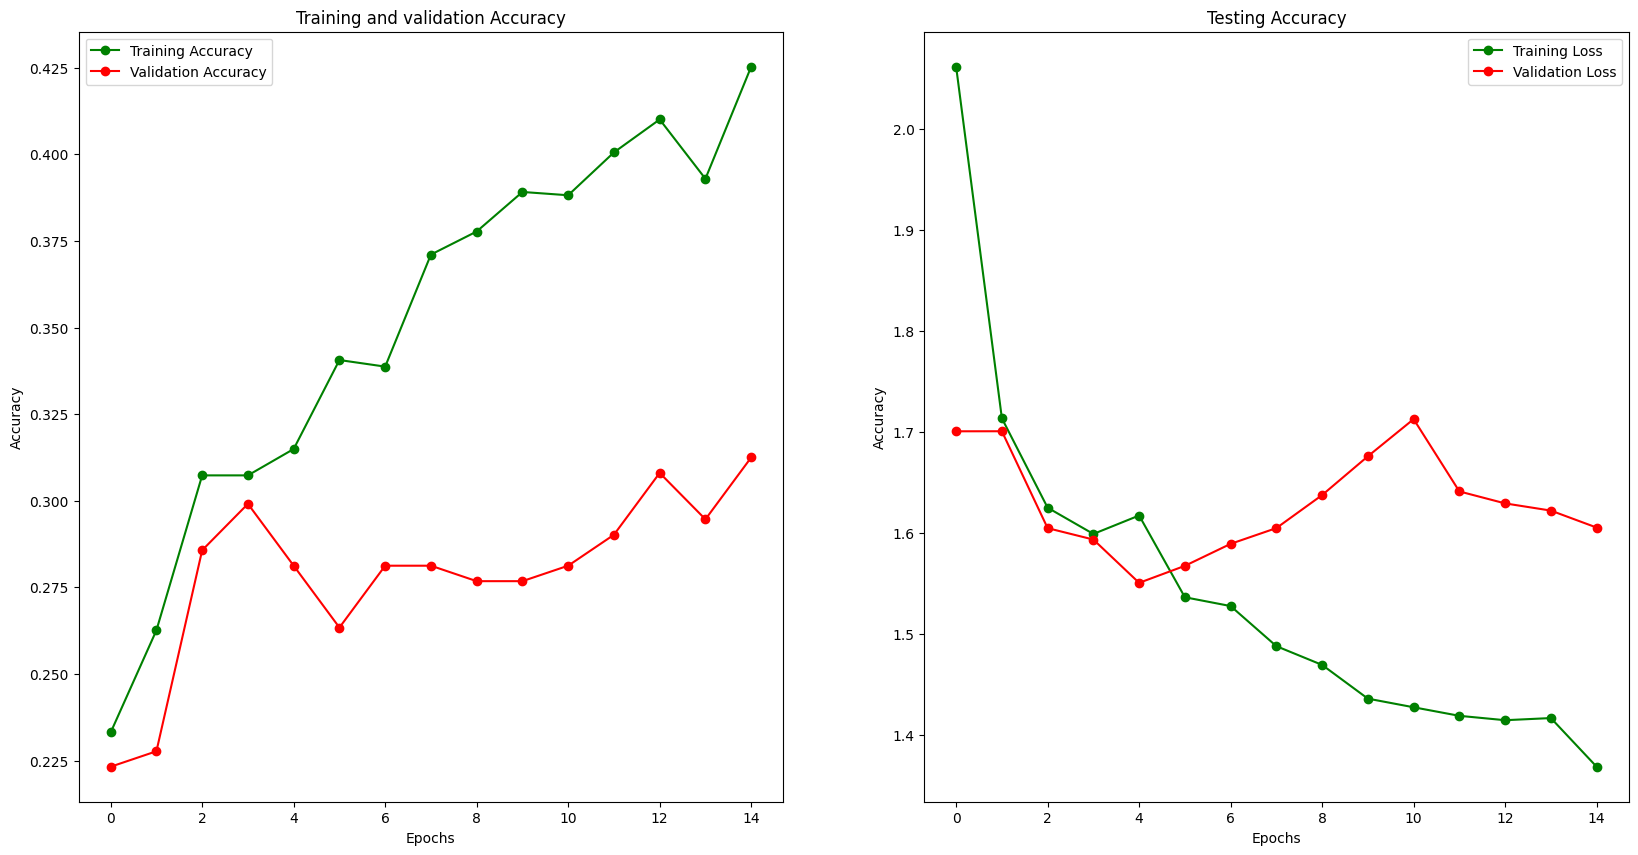

In [43]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 75ms/step


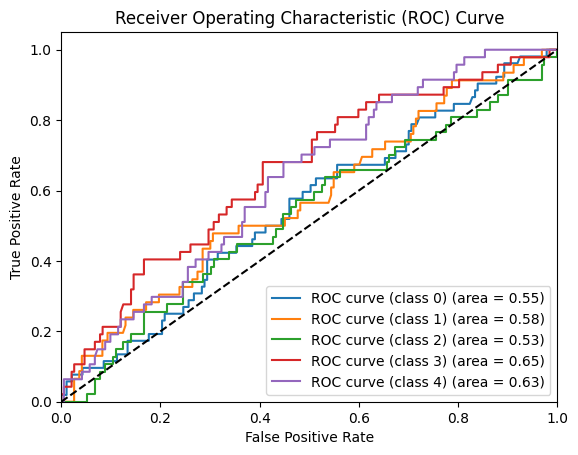

In [44]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Metric Report Calculation for Architecture No 6 

In [45]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 1s 66ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.20
Precision: 0.21
Recall: 0.20
F1 Score: 0.19
F2 Score: 0.19


In [46]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 66ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.51


# Architecture No 7

In [47]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:  # Change the number of layers to unfreeze as needed
    layer.trainable = True

top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
top_model = Dense(2048, activation= 'relu', name = 'Dense_1024')(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(1024, activation='relu', name = 'Dense_512')(top_model)
top_model = Dropout(0.3)(top_model)
top_model = Dense(512, activation='relu', name = 'Dense_64')(top_model)
predictions = Dense(num_classes, activation = 'softmax', name= 'Output_layer')(top_model)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('Architecture_no_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.8085 - accuracy: 0.2512

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 18s 423ms/step - loss: 1.8085 - accuracy: 0.2512 - val_loss: 1.6127 - val_accuracy: 0.2679
Epoch 2/50
33/33 [==============================] - 14s 424ms/step - loss: 1.5981 - accuracy: 0.3111 - val_loss: 1.6118 - val_accuracy: 0.2768
Epoch 3/50
33/33 [==============================] - 14s 425ms/step - loss: 1.5792 - accuracy: 0.3368 - val_loss: 1.5747 - val_accuracy: 0.2991
Epoch 4/50
33/33 [==============================] - 14s 430ms/step - loss: 1.5289 - accuracy: 0.3416 - val_loss: 1.5411 - val_accuracy: 0.3348
Epoch 5/50
33/33 [==============================] - 14s 418ms/step - loss: 1.4802 - accuracy: 0.3806 - val_loss: 1.5706 - val_accuracy: 0.3036
Epoch 6/50
33/33 [==============================] - 14s 415ms/step - loss: 1.4570 - accuracy: 0.3987 - val_loss: 1.6034 - val_accuracy: 0.2857
Epoch 7/50
33/33 [==============================] - 14s 416ms/step - loss: 1.4661 - accuracy: 0.3768 - val_loss: 1.6053 - val_accuracy: 0.2589
Epoch 8/50

In [49]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.2f}')

8/8 [==============================] - 1s 63ms/step - loss: 1.5888 - accuracy: 0.2678
Test accuracy: 0.27


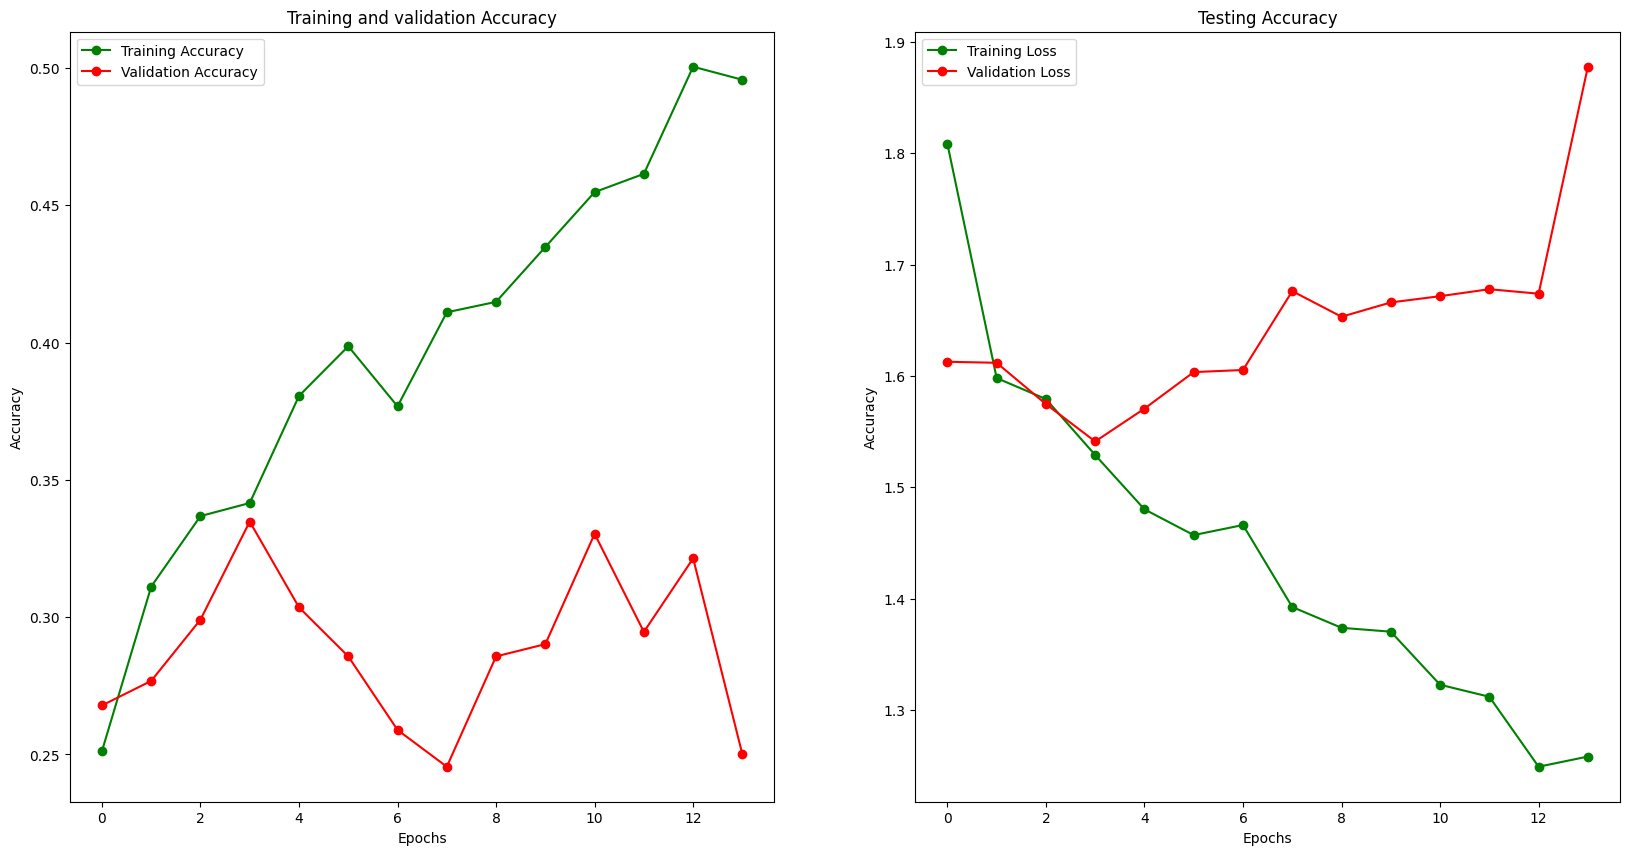

In [50]:
epochs = [i for i in range(len(history.epoch))]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training and validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'ro-', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

8/8 [==============================] - 1s 72ms/step


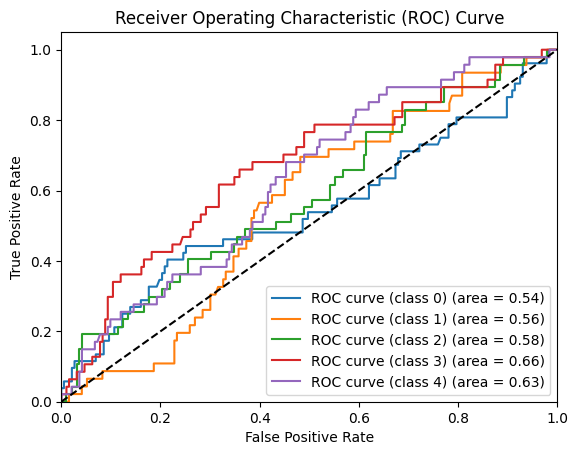

In [51]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for the test set
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Metric Report Calculation for Architecture No 7 

In [52]:
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred_classes: {len(y_pred_classes)}')

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
f2 = fbeta_score(y_true, y_pred_classes, beta=2, average='weighted')

# Print the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F2 Score: {f2:.2f}')

8/8 [==============================] - 1s 76ms/step
Length of y_true: 230
Length of y_pred_classes: 230
Accuracy: 0.22
Precision: 0.22
Recall: 0.22
F1 Score: 0.21
F2 Score: 0.21


In [53]:
# Average AUC Calculations
# Make predictions
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)
y_pred = model.predict(validation_generator, steps=val_steps)

# Ensure lengths match
y_true = validation_generator.classes
print(f'Length of y_true: {len(y_true)}')
print(f'Length of y_pred: {len(y_pred)}')

# Binarize the true labels
y_true_binarized = label_binarize(y_true, classes=range(train_generator.num_classes))

# Calculate AUC for each class
auc_scores = []
for i in range(train_generator.num_classes):
    auc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
    auc_scores.append(auc)

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f'Average AUC: {average_auc:.2f}')

8/8 [==============================] - 1s 77ms/step
Length of y_true: 230
Length of y_pred: 230
Average AUC: 0.50
